In [1]:
# Example: learning about dataframes, spark and logistic regression.
# Dataset: datasets/healthcare-dataset-stroke-data.csv
# Author: Humberto Bianchini

In [2]:
# 1) Importing all necessary libraries and Spark session creation.
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler,OneHotEncoder, StringIndexer
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.appName("Spark Task").getOrCreate()

In [3]:
# 2) Reading and showing some details about the dataset.
dataset = spark.read.format("csv").options(header="true", inferschema="true").load("healthcare-dataset-stroke-data.csv")
dataset.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [4]:
dataset.count()

5110

In [5]:
dataset.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [6]:
dataset.select('age','hypertension').show(10)

+----+------------+
| age|hypertension|
+----+------------+
|67.0|           0|
|61.0|           0|
|80.0|           0|
|49.0|           0|
|79.0|           1|
|81.0|           0|
|74.0|           1|
|69.0|           0|
|59.0|           0|
|78.0|           0|
+----+------------+
only showing top 10 rows



In [7]:
dataset.groupBy("gender").count().sort("count",ascending=True).show()

+------+-----+
|gender|count|
+------+-----+
| Other|    1|
|  Male| 2115|
|Female| 2994|
+------+-----+



In [8]:
dataset.groupby('smoking_status').count().sort("count",ascending=True).show()

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes|  789|
|formerly smoked|  885|
|        Unknown| 1544|
|   never smoked| 1892|
+---------------+-----+



In [9]:
dataset.groupby('hypertension').count().sort("count",ascending=True).show()

+------------+-----+
|hypertension|count|
+------------+-----+
|           1|  498|
|           0| 4612|
+------------+-----+



In [10]:
dataset.groupby('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



In [11]:
dataset.filter(dataset.gender== 'Female').count()

2994

In [12]:
dataset.groupBy("work_type").agg({'work_type': 'count'}).sort(asc("count(work_type)")).show()

+-------------+----------------+
|    work_type|count(work_type)|
+-------------+----------------+
| Never_worked|              22|
|     Govt_job|             657|
|     children|             687|
|Self-employed|             819|
|      Private|            2925|
+-------------+----------------+



In [13]:
numeric_values  = ['age',"avg_glucose_level", "bmi"]
dataset.describe(numeric_values).show(truncate=False)

+-------+------------------+------------------+------------------+
|summary|age               |avg_glucose_level |bmi               |
+-------+------------------+------------------+------------------+
|count  |5110              |5110              |5110              |
|mean   |43.226614481409015|106.14767710371804|28.893236911794673|
|stddev |22.61264672311348 |45.28356015058193 |7.85406672968016  |
|min    |0.08              |55.12             |10.3              |
|max    |82.0              |271.74            |N/A               |
+-------+------------------+------------------+------------------+



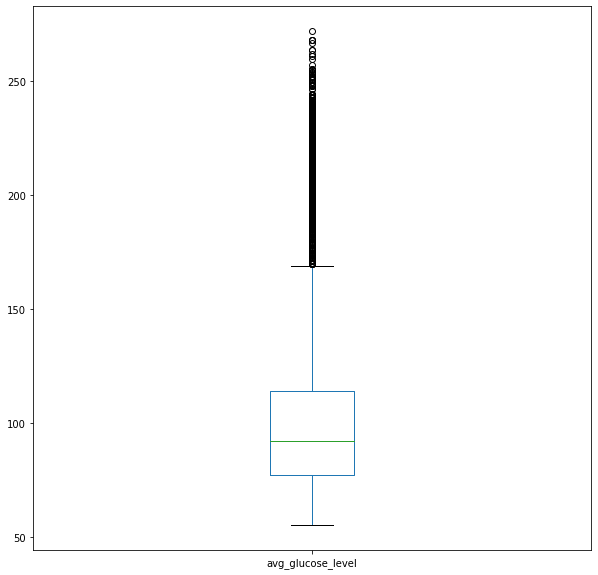

In [14]:
df = dataset.toPandas()
df['avg_glucose_level'].plot(kind='box', figsize=(10,10));

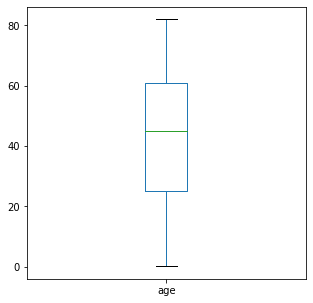

In [15]:
df['age'].plot(kind='box', figsize=(5,5));

In [16]:
dataset.groupby('Residence_type').agg({'Residence_type': 'count'}).sort(asc("count(Residence_type)")).show()

+--------------+---------------------+
|Residence_type|count(Residence_type)|
+--------------+---------------------+
|         Rural|                 2514|
|         Urban|                 2596|
+--------------+---------------------+



In [17]:
# 3) Setting up for Logistic Regression.
mean = dataset.select(mean(dataset['bmi'])).collect()
mean_bmi = mean[0][0]
dataset = dataset.na.fill(mean_bmi,['bmi'])

In [18]:
filterDataset = dataset.filter((dataset['bmi'] != 'N/A') & (dataset['smoking_status'] > 'Unknown'))

In [19]:
stringIndexer_gender=StringIndexer(inputCol="gender", outputCol="gender_encoded")
encoder_gender = OneHotEncoder(dropLast=False, inputCol="gender_encoded", outputCol="genderVec")

In [20]:
stringIndexer_married=StringIndexer(inputCol="ever_married", outputCol="ever_married_encoded")
encoder_married = OneHotEncoder(dropLast=False, inputCol="ever_married_encoded", outputCol="marriedVec")

In [21]:
stringIndexer_work=StringIndexer(inputCol="work_type", outputCol="work_type_encoded")
encoder_work = OneHotEncoder(dropLast=False, inputCol="work_type_encoded", outputCol="workVec")

In [22]:
stringIndexer_residence=StringIndexer(inputCol="Residence_type", outputCol="Residence_type_encoded")
encoder_residence = OneHotEncoder(dropLast=False, inputCol="Residence_type_encoded", outputCol="residenceVec")

In [23]:
stringIndexer_smoking=StringIndexer(inputCol="smoking_status", outputCol="smoking_status_encoded")
encoder_smoking = OneHotEncoder(dropLast=False, inputCol="smoking_status_encoded", outputCol="smokingVec")

In [24]:
inputColumns = ['age','hypertension', 'heart_disease','avg_glucose_level','genderVec','marriedVec','workVec','residenceVec','smokingVec']
inputVector = VectorAssembler(inputCols=inputColumns,outputCol='features')

In [25]:
transformations = [stringIndexer_gender,stringIndexer_married,stringIndexer_work,stringIndexer_residence,stringIndexer_smoking,encoder_gender,encoder_married,encoder_work,encoder_residence,encoder_smoking,inputVector]

In [26]:
# 4) Starting the pipeline.
pipeline = Pipeline(stages=transformations)
pipelineModel = pipeline.fit(filterDataset)
model = pipelineModel.transform(filterDataset)

In [27]:
model.select('age','gender','genderVec','ever_married','marriedVec','features').show()

+----+------+-------------+------------+-------------+--------------------+
| age|gender|    genderVec|ever_married|   marriedVec|            features|
+----+------+-------------+------------+-------------+--------------------+
|67.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,5,7,9,...|
|80.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,5,7,9,...|
|49.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,4,7,9,14...|
|79.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,3,4,7,10...|
|81.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,5,7,9,14...|
|74.0|  Male|(3,[1],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,2,3,5,7,...|
|69.0|Female|(3,[0],[1.0])|          No|(2,[1],[1.0])|(19,[0,3,4,8,9,14...|
|81.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,1,3,4,7,9,...|
|61.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,2,3,4,7,11...|
|54.0|Female|(3,[0],[1.0])|         Yes|(2,[0],[1.0])|(19,[0,3,4,7,9,14...|
|79.0|Female

In [28]:
# 5) Setting up the Train/Test data.
train_data, test_data = model.randomSplit([.8,.2],seed=1)

In [29]:
train_data.columns

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke',
 'gender_encoded',
 'ever_married_encoded',
 'work_type_encoded',
 'Residence_type_encoded',
 'smoking_status_encoded',
 'genderVec',
 'marriedVec',
 'workVec',
 'residenceVec',
 'smokingVec',
 'features']

In [30]:
# 6) Logistic Regression
lr = LogisticRegression(labelCol="stroke",featuresCol="features", maxIter=100, regParam=0.3, )
linearModel = lr.fit(train_data)
regressionPrediction = linearModel.transform(test_data)
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
accuracy = acc_evaluator.evaluate(regressionPrediction)
print(f'Logistic Regression Accuracy: {accuracy*100}%')

Logistic Regression Accuracy: 94.30656934306569%
